In [1]:
#Hello numpy
import numpy as np
%matplotlib inline
print('Hello');
np.absolute(-3)

Hello


3

LizNelson_Rainfall/LizNelson_Rainfall_MIX.wav
pysoundfile time
0.1000058650970459
wavfile time
0.047002553939819336


C:\ProgramData\Anaconda3\lib\site-packages\scipy\io\wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


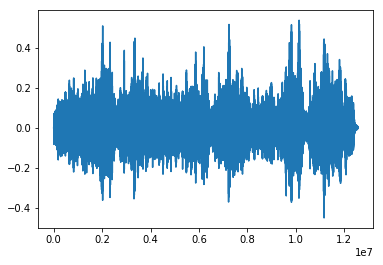

In [2]:
#read json, read mix from sample and plot
from scipy.io import wavfile
import json
from pprint import pprint
import time
import matplotlib.pyplot as plt
import soundfile as sf


data = json.load(open('medleydb_deepkaraoke.json')) #dictionary

print(data["mixes"][50]["mix_path"])
#print(data['base_path'])

mixname = data['base_path']+data["mixes"][50]["mix_path"]
other_stems_str = [data['base_path']+f for f in data["mixes"][50]["other_stems"]]
target_stems_str = [data['base_path']+f for f in data["mixes"][50]["target_stems"]]


print('pysoundfile time')
start = time.time()
mix,samplerate = sf.read(mixname);
end = time.time()
print(end-start)


print('wavfile time')
start = time.time()
fcwv, mixwv = wavfile.read(mixname)
end = time.time()
print(end-start)

#print(mix)
#print(mixwv)

n_samples = len(mix);

mono = np.mean(mix,1)


plt.plot(mono);
plt.show() 

In [59]:
out = np.apply_along_axis(np.mean,1,np.array([[1,2,3],[3,4,5],[2,3,4]]))
print(out)

[ 2.  4.  3.]


In [3]:
#create stems mats
def create_stems_mat(stems_str,n_samples):
    stems_mat = np.zeros((len(stems_str),n_samples))    
    for i,f in  enumerate(stems_str):
        sig, samplerate = sf.read(f)
        stems_mat[i,:] = np.mean(sig,1) #make stereo signal into mono
    return stems_mat

other_stems_mat = create_stems_mat(other_stems_str,n_samples)
target_stems_mat = create_stems_mat(target_stems_str,n_samples)



In [5]:
# x = np.array([[1,2,3],[2,3,4]])
# func = lambda x: x/np.max(np.abs(x))
# np.apply_along_axis(func,1,x)

def mix_stems(stems):
    func = lambda x: x/np.max(np.abs(x))
    stems = np.apply_along_axis(func,1,stems)  #normalize stem to be max 1 (carefully check the range!! TBD)
    n_stems = stems.shape[0]
    return stems.sum(0)/n_stems                #add all stems with equal weights


other  = mix_stems(other_stems_mat)
vocals = mix_stems(target_stems_mat)
mix_tot = 0.5*other + 0.5*vocals

In [6]:
from scipy import signal

def normalize(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))

class struct(object):
    pass

options = struct();
options.L = 20; # number of stacked frames
options.H = 60; # Training data resample hop
options.N_BINS = 1025; #number of FFT bins
options.FFT_SIZE = 2 * (options.N_BINS-1); # STFT FFT size
options.HOP_SIZE = 512; # STFT hop size 
options.N_ITER = 100; # number of iterations
overlap = options.FFT_SIZE - options.HOP_SIZE # this is in the matlab code, in the paper the overlap is the hop size


# mono for all the mix
# mono_n = normalize(mono)

# fs, ts, Sxx = signal.spectrogram(mono[1000:samplerate*20], samplerate, 'hann', options.FFT_SIZE, overlap)
# print('spectogram')
# print(Sxx.shape)
# plt.pcolormesh(ts, fs, np.log(Sxx))#,vmin=0, vmax=np.max(Sxx))
# plt.title('Spectogram')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.colorbar()


# f, t, Zxx = signal.stft(mono[1000:samplerate*20], samplerate, 'hann', options.FFT_SIZE, overlap)
# print('stft')
# print(Zxx.shape)
# plt.pcolormesh(t, f, np.log(np.abs(Zxx)**2))
# plt.title('STFT Magnitude sqr')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.colorbar()


In [7]:
# try to restore
#t,restored = signal.istft(Zxx,samplerate, 'hann', options.FFT_SIZE, overlap)
#sf.write('../restored.wav',restored,samplerate)

NameError: name 'Zxx' is not defined

In [194]:
#listen to signal
from IPython.display import Audio
Audio(data=mono, rate=samplerate)
#Audio(url="http://www.w3schools.com/html/horse.ogg")

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.


stft
(1025, 24541)
stft
(1025, 24541)


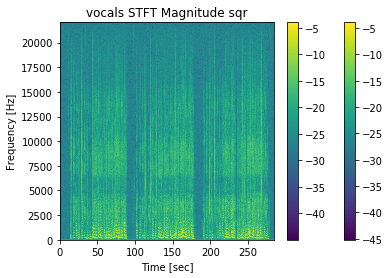

In [9]:

f, t, Zotherxx = signal.stft(other, samplerate, 'hann', options.FFT_SIZE, overlap)
# print('stft')
# print(Zotherxx.shape)
# plt.pcolormesh(t, f, np.log(np.abs(Zotherxx)**2))
# plt.title('other STFT Magnitude sqr')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.colorbar()

f, t, Zvocalsxx = signal.stft(vocals, samplerate, 'hann', options.FFT_SIZE, overlap)
# print('stft')
# print(Zvocalsxx.shape)
# plt.pcolormesh(t, f, np.log(np.abs(Zvocalsxx)**2))
# plt.title('vocals STFT Magnitude sqr')
# plt.ylabel('Frequency [Hz]')
# plt.xlabel('Time [sec]')
# plt.colorbar()

f, t, Zmix_totxx = signal.stft(mix_tot, samplerate, 'hann', options.FFT_SIZE, overlap)


In [11]:
#sample frames of stft with H,L - hop, length ,can have overlap
#toy example
# x = [1,2,3,4,5,6,7,8]
# y = [[1,2,3],[3,4,5],[5,6,7]]
# h = 2
# n = np.floor(len(x)/2)
# if (h*(n-1) + 3 > len(x)):
#     n-=1
# print(n)
# np.linspace(0,h*(n-1), n)

def sample_to_col_blocks(sig,H,L):
    n_blocks = int(np.floor(sig.shape[1]/H))
    if (n_blocks-1)*H + L > sig.shape[1] :
        n_blocks-=1
    return [sig[:, i:i + L] for i in np.arange(0, n_blocks * H, H)] # n samples, the last one is (n_blocks-1)*H
    

In [12]:
voc_blks   = sample_to_col_blocks(Zvocalsxx,options.H,options.L)
other_blks = sample_to_col_blocks(Zotherxx,options.H,options.L)
mix_blks   = sample_to_col_blocks(Zmix_totxx,options.H,options.L)

bin_mask_blks = [np.abs(voc_blks[i]) > np.abs(other_blks[i])  for i in range(0,len(mix_blks))] # check that this is an np.array and the output is a vector

train_data = struct();
train_data.mix_blks = mix_blks;
train_data.bin_mask_blks = bin_mask_blks;
train_data.voc_blks = voc_blks;
train_data.other_blks = other_blks;

import pickle

f = open('train_data.pckl', 'wb')
pickle.dump(train_data, f)
f.close()

f = open('train_data.pckl', 'rb')
train_data_in = pickle.load(f)
f.close()


#import scipy.io
#rms = [np.sqrt(np.mean(block**2)) for block in
#       sf.blocks('myfile.wav', blocksize=1024, overlap=512)]


#mat = scipy.io.loadmat('file.mat')

In [ ]:
#process network output into separated signals
def voc_prob_to_col_mask(alpha,sigm_prob):
   return np.apply_along_axis(lambda x: 1.0 if (np.mean(x)/ > alpha) else 0.0 ,1,sigm_prob)
    
def other_prob_to_col_mask(alpha,sigm_prob):
    return np.apply_along_axis(lambda x: 1.0 if (np.mean(x) < 1 - alpha) else 0.0 ,1,sigm_prob)

def nn_out_to_separated_sigs(mix_stft, masks_list, alpha, samplerate,FFT_SIZE,overlap):
    # masks_list should be in the size of cols on stft  - this issue should be resolved.   
    voc_mask = np.array([voc_prob_to_col_mask(alpha,sigm_prob)  for sigm_prob in masks_list])
    t,sep_voc = signal.istft(mix_stft*voc_mask,samplerate, 'hann', FFT_SIZE, overlap)
    other_mask = np.array([other_prob_to_col_mask(alpha,sigm_prob)  for sigm_prob in masks_list])
    t,sep_other = signal.istft(mix_stft*other_mask,samplerate, 'hann', FFT_SIZE, overlap)

    return sep_voc,sep_other
    